<a href="https://colab.research.google.com/github/matteoramaconsulting/Github-Ranking/blob/master/mmm_ConTe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install lightweight_mmm==0.1.6
%pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.4 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=ea05a7d87138a1d88e4263d8ab47cc81e00f55aee7d2f5bb6d0c29a83efdf112
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1
  Attempting uninstall: lightweight_mmm
    Found existing installation: lightweight-mmm 0.1.7
    Uninstalling lightweight-mmm-0.1.7:
      Successfully uninstalled lightweight-mmm-0.1.7


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully uninstalled numpy-1.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 4.1.4 requires arviz>=0.12.0, but you have arviz 0.11.2 which is incompatible.


In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import models
from lightweight_mmm import media_transforms
import pandas as pd
import numpy as np
from lightweight_mmm import plot

In [2]:
df = pd.read_csv("db_conTe.csv")
del df['Unnamed: 0']
target = "kpi_brandAwarness"
mean_kpi = [kpi for kpi in df.columns if '_mean' in kpi]
max_kpi = [kpi for kpi in df.columns if '_max' in kpi]
min_kpi = [kpi for kpi in df.columns if '_min' in kpi]

costs = [kpi for kpi in df.columns if 'spent_' in kpi]
media = [kpi for kpi in df.columns if 'grp_' in kpi]
kpi   = [kpi for kpi in df.columns if 'kpi_' in kpi]

df["date"] = pd.to_datetime(df["date"])

mean_kpi = [kpi for kpi in df.columns if '_mean' in kpi]
max_kpi = [kpi for kpi in df.columns if '_max' in kpi]
min_kpi = [kpi for kpi in df.columns if '_min' in kpi]

# come primo tentativo prendiamo solo le metriche di valor medio,
# anche se probabilmente, vista l'alta varianza, poco significative

df = df.drop(columns=["grp_competitor_mean"]+max_kpi + min_kpi)

costs_cols = [kpi for kpi in df.columns if 'spent_' in kpi]
media_data_cols = [kpi for kpi in df.columns if 'grp_' in kpi]
extra_features_cols = [kpi for kpi in df.columns if 'kpi_' in kpi]
extra_features_cols.remove(target)

n_media_channels = len(media_data_cols)
n_extra_features = len(extra_features_cols)

df = df.set_index("date").replace(0,np.nan).resample("W").mean()[:-13]

SEED = 42
data_size = len(df)

media_data = jnp.array(df[["grp_ConTe","grp_mean_competitortv","grp_mean_competitorRadio"]].fillna(0))
costs = jnp.array([
    df["spent_tv_ConTe"].sum(),
    df["spent_tv_competitor_mean"].sum(),
    df["spent_radio_competitor_mean"].sum()

])
extra_features = jnp.array(df[["kpi_covid","spent_internet competitor_mean",
                              "spent_newspaper_competitor_mean",
                              "spent_cinema_competitor_mean",
                              "spent_magazines_competitor_mean",
                              "spent_ooh_competitor_mean"]].fillna(0))
target = jnp.array(df[target].fillna(0))

# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)

target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

number_warmup=1000#10000
number_samples=1000#10000

In [3]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED)
mmm.print_summary()

/usr/local/lib/python3.8/dist-packages/lightweight_mmm/lightweight_mmm.py:357: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [01:25<00:00, 23.26it/s, 255 steps of size 1.08e-02. acc. prob=0.89]



                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.80      0.16      0.84      0.59      0.98    788.64      1.00
ad_effect_retention_rate[1]      0.63      0.27      0.67      0.21      0.99   1400.23      1.00
ad_effect_retention_rate[2]      0.55      0.27      0.58      0.15      0.99   1625.56      1.00
     coef_extra_features[0]      0.01      0.01      0.01     -0.00      0.02   1046.69      1.00
     coef_extra_features[1]      0.01      0.01      0.01     -0.01      0.03   1031.17      1.00
     coef_extra_features[2]     -0.01      0.01     -0.01     -0.03      0.01   1227.33      1.00
     coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01   1796.22      1.00
     coef_extra_features[4]      0.01      0.01      0.01     -0.01      0.03   1251.82      1.00
     coef_extra_features[5]     -0.01      0.01     -0.01     -0.02      0.01   1107.05      1.00
              coef_

In [5]:
channel_media_names =["grp_ConTe","grp_mean_competitortv","grp_mean_competitorRadio"] 

In [ ]:
#plot.plot_media_channel_posteriors(media_mix_model=mmm,channel_names=channel_media_names)

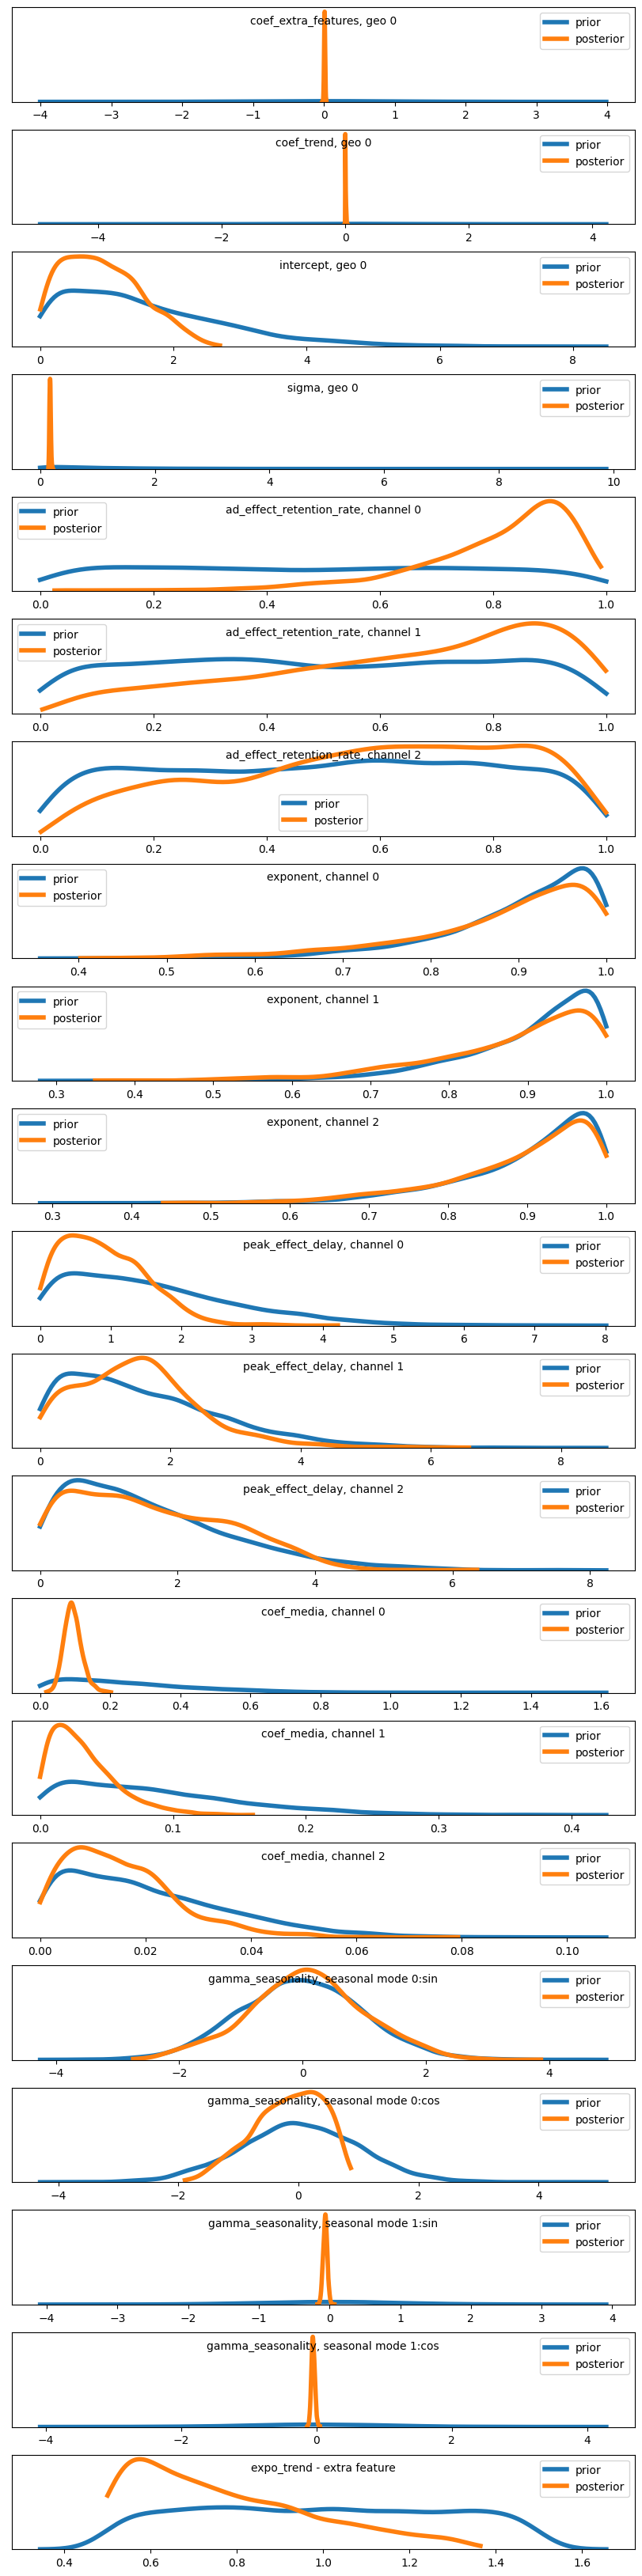

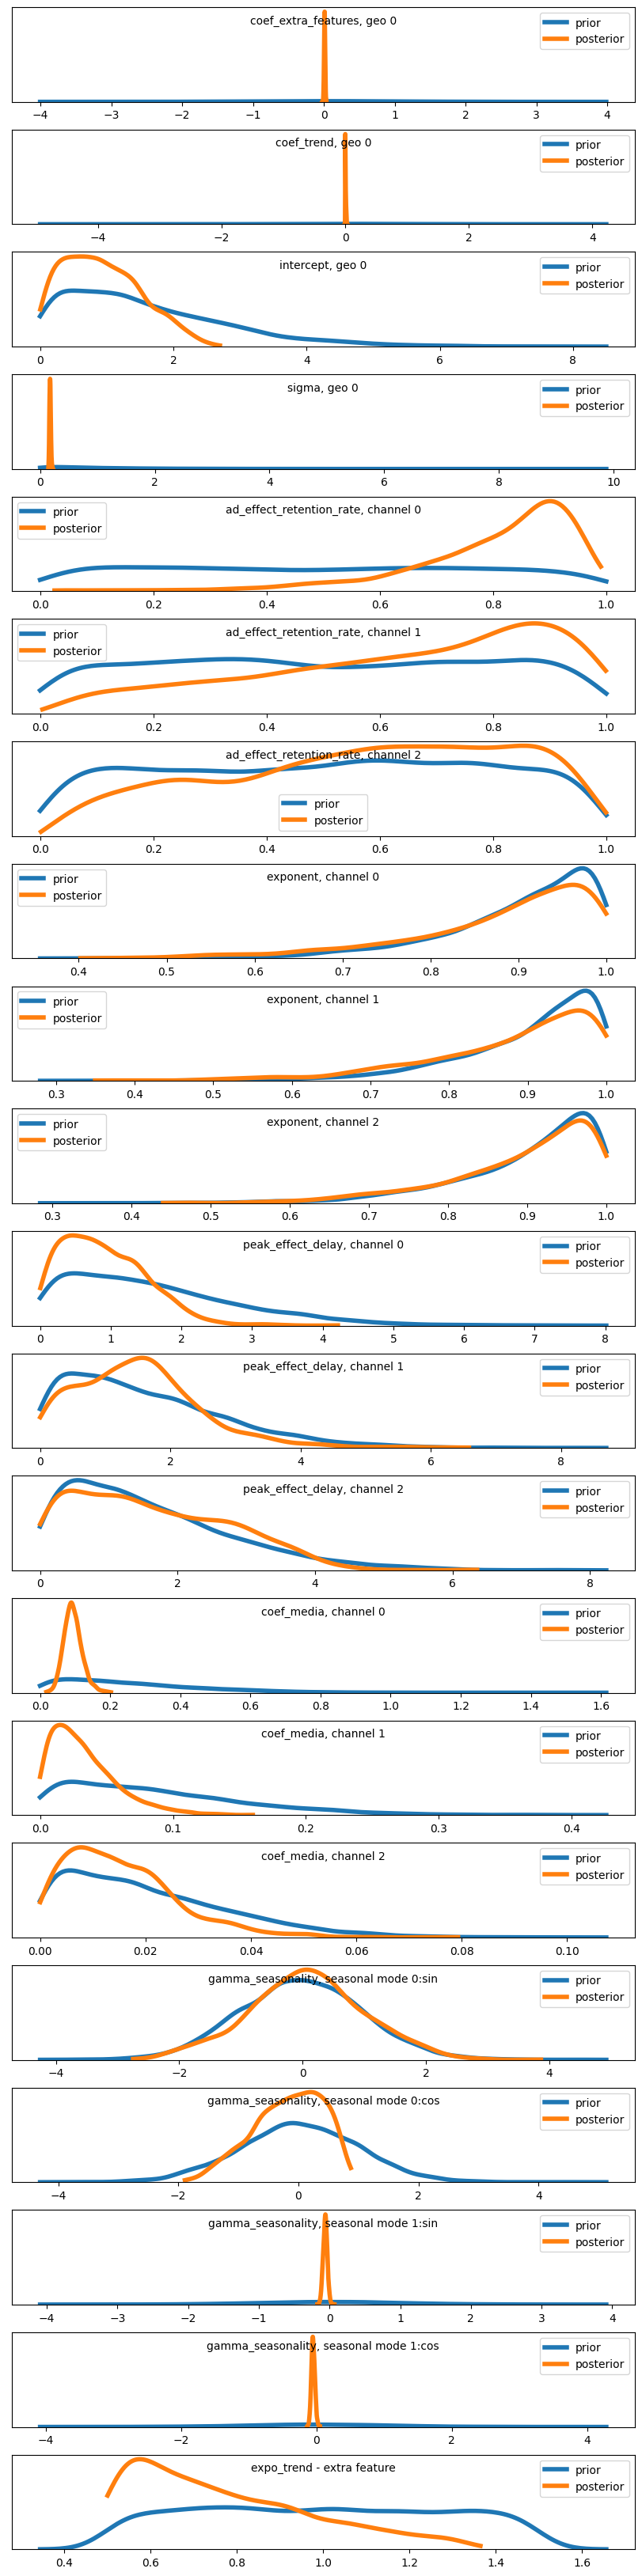

In [6]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats_utils.py:505: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.8/dist-packages/arviz/stats/stats_utils.py (507)

File "../usr/local/lib/python3.8/dist-packages/arviz/stats/stats_utils.py", line 507:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats_utils.py:505: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../usr/local/lib/python3.8/dist-packages/arviz/stats/stats_utils.py", line 508:
def stats_variance_1d(data, ddof=0):
    <source elided>
    a_a, b_b = 0, 0
    for i in data:


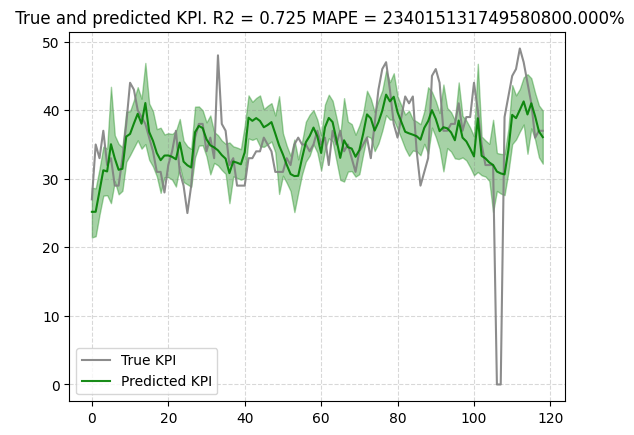

In [7]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [8]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13)

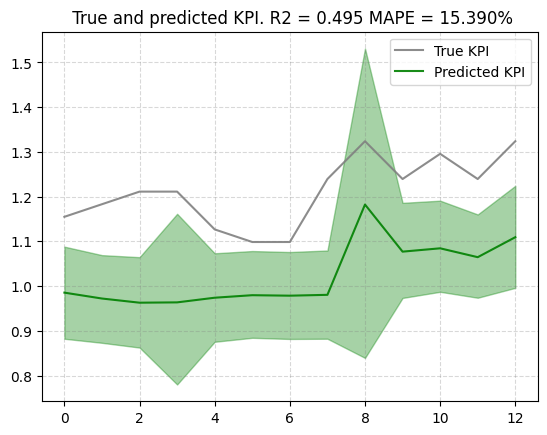

In [9]:

plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

In [10]:
# The average media contribution percentage for each channel
# The return on investment of each channel calculated as its contribution divided by the cost
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

In [11]:
import seaborn as sns
sns.color_palette("mako")

baseline = plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names=['media_1','media_2','media_3'])

In [12]:
df_contribution = plot.create_media_baseline_contribution_df(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                channel_names=['media_1','media_2','media_3'])

df_contribution.head()

,media_1_percentage,media_2_percentage,media_3_percentage,baseline_percentage,avg_prediction,media_1 contribution,media_2 contribution,media_3 contribution,baseline contribution,period
0,0.0,0.0,0.0,1.000000,25.179707,0.000000,0.0,0.0,25.179707,1
1,0.0,0.0,0.0,1.000000,25.184603,0.000000,0.0,0.0,25.184603,2
2,0.10965671,0.0,0.0,0.890343,28.200676,3.092393,0.0,0.0,25.108282,3
3,0.19839852,0.0,0.0,0.801601,31.240444,6.198058,0.0,0.0,25.042385,4
4,0.19527106,0.0,0.0,0.804729,31.065918,6.066275,0.0,0.0,24.999643,5


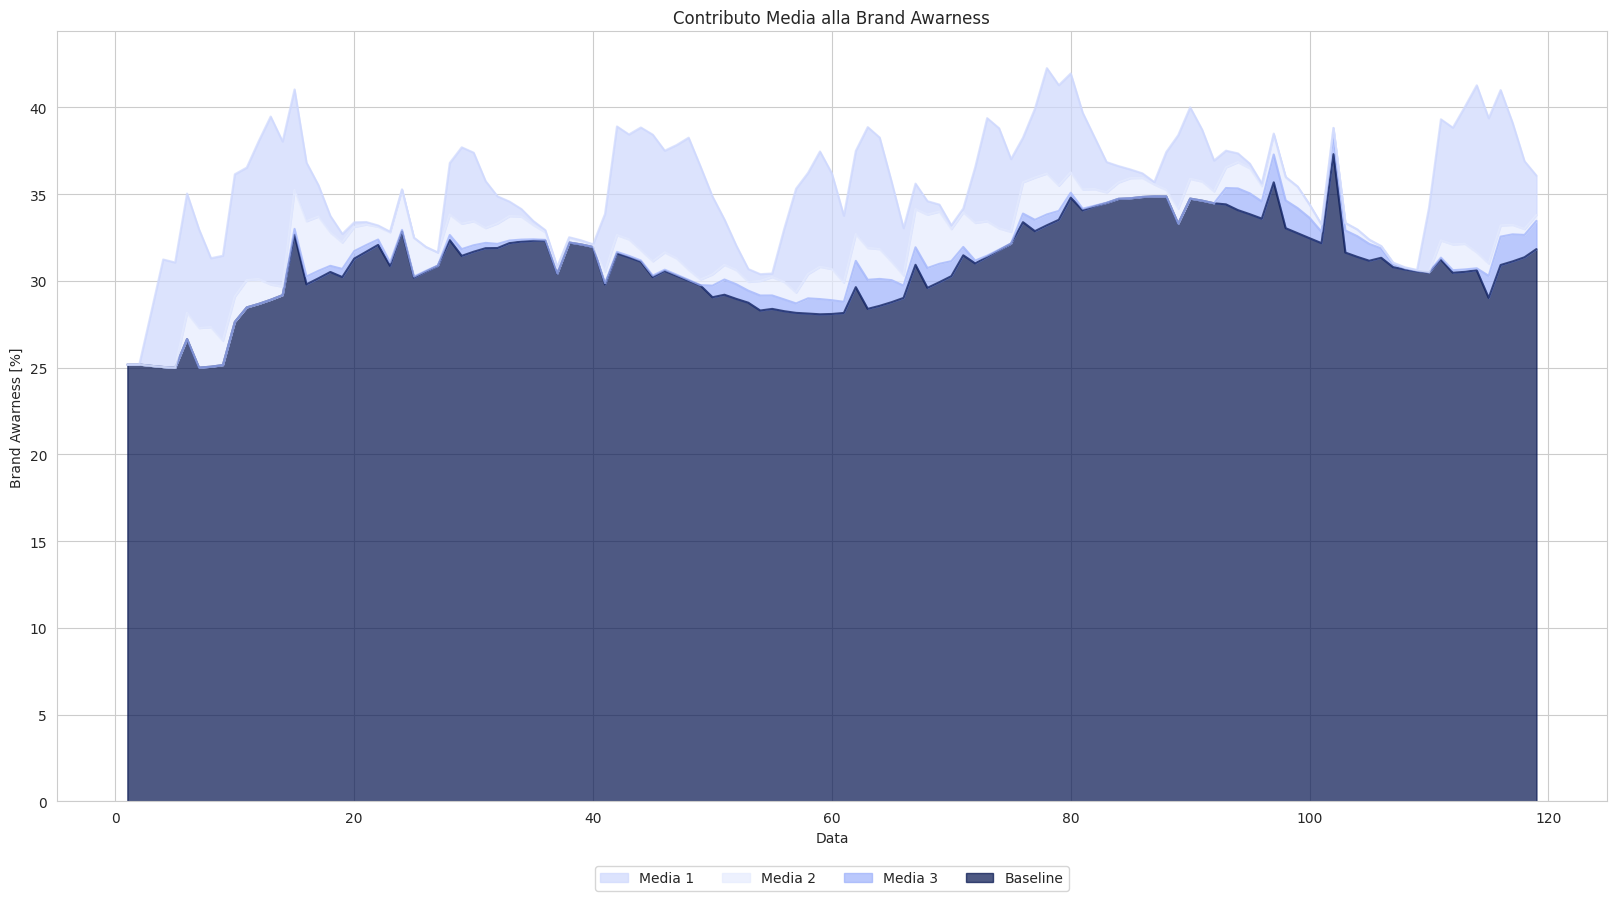

In [13]:
sns.set_style("whitegrid")
import matplotlib.pyplot as plt


contribution_columns = [
      col for col in df_contribution.columns if "contribution" in col]
contribution_df_for_plot = df_contribution.loc[:, contribution_columns]
contribution_df_for_plot = contribution_df_for_plot[contribution_df_for_plot.columns[::-1]]
period = np.arange(1, contribution_df_for_plot.shape[0] + 1)
contribution_df_for_plot.loc[:, "period"] = period

# Plot the stacked area chart.
fig, ax = plt.subplots()
contribution_df_for_plot.plot.area(x="period", stacked=True, figsize=[20,10], ax=ax,
                                   color=["#03134F","#9DB1FB","#E6ECFE","#CED8FD"],alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Data")
ax.set_ylabel("Brand Awarness [%]")
ax.set_title("Contributo Media alla Brand Awarness")
ax.legend(handles[::-1], ["Media 1","Media 2","Media 3","Baseline"],loc="center", bbox_to_anchor=(0.5, -0.1),ncol=4,fancybox=True,)
fig.savefig("plot_media_baseline_contribution_area_plot.png")

In [ ]:
df_contribution.baseline_percentage.mean()

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage",
                             channel_names=['media_1','media_2','media_3'])

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=['media_1','media_2','media_3'])

In [ ]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

In [ ]:

prices = jnp.ones(mmm.n_media_channels)
n_time_periods = 10 ## forecast 10 settimane
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
print(optimal_buget_allocation)

# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
print(previous_budget_allocation)

# Both these values should be very close in order to compare KPI
print(budget, optimal_buget_allocation.sum())

# Both numbers should be almost equal
print(budget, jnp.sum(solution.x * prices))



In [ ]:
for x in range(len(solution.x)):
  share = np.round(solution.x[x]/jnp.sum(solution.x*prices)*100,2)
  print(['media_1','media_2','media_3'][x],": ", str(share), "%")


In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
import seaborn as sns
sns.set_style("whitegrid")
plot_pre_post_budget_allocation_comparison = plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10),
                                                channel_names=['media_1','media_2','media_3'])

plot_pre_post_budget_allocation_comparison.savefig("mmm_plot_pre_post_budget_allocation_comparison.png")

In [ ]:
channel_names=['media_1','media_2','media_3']
media_mix_model = mmm
kpi_with_optim=solution['fun']
kpi_without_optim=kpi_without_optim,
optimal_buget_allocation=jnp.array([566.3764,246.74681,141.55081]) 
previous_budget_allocation= jnp.array([486.65344,297.40735,170.61316])
figure_size=(8,4)
previous_budget_allocation_pct = previous_budget_allocation / jnp.sum(previous_budget_allocation)
optimized_budget_allocation_pct = optimal_buget_allocation / jnp.sum(optimal_buget_allocation)

if channel_names is None:
  channel_names = media_mix_model.media_names
x_axis = np.arange(len(channel_names))

pre_optimizaiton_predicted_target = kpi_without_optim * -1
post_optimization_predictiond_target = kpi_with_optim * -1
predictions = [
    pre_optimizaiton_predicted_target, post_optimization_predictiond_target
]

# Create bar chart.
fig, axes = plt.subplots(1, 1, figsize=figure_size,dpi=150)
colors=sns.color_palette("mako",2)
plots1 = axes.bar(
    x_axis - 0.2,
    previous_budget_allocation,
    width=0.4,
    label="previous budget allocation",
    color=colors[0],alpha=0.7)
plots2 = axes.bar(
    x_axis + 0.2,
    optimal_buget_allocation,
    width=0.4,
    label="optmized buget allocation",color=colors[1],alpha=0.7)
axes.set_ylabel("Budget Allocation", fontsize="x-large")
axes.set_title(
    "Confronto Ottimizzazione Allocazione Budget",
    fontsize="x-large")
# Iterrating over the bars one-by-one.
for bar_i in range(len(plots1.patches)):
  bar = plots1.patches[bar_i]
  axes.annotate(
      "{:.0%}".format(previous_budget_allocation_pct[bar_i]),
      (bar.get_x() + bar.get_width() / 2, bar.get_height()-20),
      ha="center",
      va="center",
      size=10,
      xytext=(0, 8),
      textcoords="offset points")

# Iterrating over the bars one-by-one.
for bar_i in range(len(plots2.patches)):
  bar = plots2.patches[bar_i]
  axes.annotate(
      "{:.0%}".format(optimized_budget_allocation_pct[bar_i]),
      (bar.get_x() + bar.get_width() / 2, bar.get_height()-20),
      ha="center",
      va="center",
      size=10,
      xytext=(0, 8),
      textcoords="offset points")

axes.set_xticks(x_axis)
axes.set_xticklabels(channel_names, fontsize="medium")
handles, labels = axes.get_legend_handles_labels()
axes.set_title("Confronto Ottimizzazione Allocazione Budget")
axes.legend(handles[::-1], labels[::-1],loc="center", bbox_to_anchor=(0.5, -0.2),ncol=2,fancybox=True,)

fig.savefig("mmm_plot_pre_post_budget_allocation_comparison.png")

In [ ]:
grp2023_4mil = jnp.array([200,
200,
0,
0,
0,
200,
200,
0,
0,
200,
200,
0,
0,
200,
200,
0,
0,
0,
0,
200,
200,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
200,
200,
0,
0,
200,
200,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0])

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

colors=sns.color_palette("mako",3)

df_pred = pd.DataFrame()

df_pred["date"] = pd.date_range(start="01/08/2023", end="01/07/2024",periods=53).date
df_pred["month"] = pd.to_datetime(df_pred.date).dt.month
df_pred["hue_month"] = df_pred["month"] > 9 
df_pred["grp"] = jnp.array(grp2023_4mil)
df_pred["grp_adstock"] = media_transforms.hill(jnp.array(grp2023_4mil,dtype=jnp.float32),half_max_effective_concentration=2.04,slope=1.46) + \
          media_transforms.adstock(jnp.array(grp2023_4mil,dtype=jnp.float32),lag_weight=0.83 )
df_pred["grp_adstock_baseline"] = df_pred["grp_adstock"] + df_pred["grp"]*0.7758943

fig,ax = plt.subplots(figsize=[10,4],dpi=150)

sns.barplot(data=df_pred, x="date", y="grp",ax=ax,color=colors[0],label='GRP')
ax2 = ax.twinx()
df_pred.grp_adstock.plot(ax=ax2,color=colors[1],linewidth=3,label='Decadimento') 
plt.xticks(rotation=70)
ax2.set_xticklabels("")
ax.set_xlabel("Data")
ax.set_ylabel("GRP")
ax.set_title("Andamento GRP\n Modello Adstock Geometrico")
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.savefig("Decay_GRP.png")
print('')


In [ ]:
media_transforms.hill(jnp.array(grp2023_4mil,dtype=jnp.float32),half_max_effective_concentration=2.04,slope=1.46) + \
          media_transforms.adstock(jnp.array(grp2023_4mil,dtype=jnp.float32),lag_weight=0.83 )